In [8]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

import matplotlib.pyplot as plt

import backtest as bt
import risk_parity as rp

# Purpose of the Notebook

Find reference portfolio and the variants:
- monthly
- quarterly
- semi-annually
- annually
- vix-adjusted frequency

# All Weather

- 30% Stock
- 55% Bond
 - 15% 20-Yr
 - 40% 3-Yr
- 15% Commodity
 - 7.5% Gold
 - 7.5% Broad

In [2]:
# equity
stock = pd.read_csv('data/S&P 500 Total Return Index.csv',index_col=0).iloc[2:,1]
stock = stock.astype('float')
stock.index = pd.to_datetime(stock.index)
stock = stock.pct_change().apply(lambda x: np.log(1+x))

# constant maturity rate for 20 years - annualized rates
long_bond = pd.read_csv('data/DGS20.csv',index_col=0)
long_bond.loc[long_bond['DGS20']=='.'] = 0
long_bond = pd.to_numeric(long_bond['DGS20'], errors = 'ignore').dropna()
# since FRED expressed returns in annual % form, we convert back to decimal monthly return
long_bond = (1+long_bond).apply(np.log)/360/100
long_bond.index = pd.to_datetime(long_bond.index)

# constant maturity rate for 3 years
short_bond = pd.read_csv('data/DGS3.csv',index_col=0)
short_bond.loc[short_bond['DGS3']=='.'] = 0
short_bond = pd.to_numeric(short_bond['DGS3'], errors = 'ignore').dropna()
short_bond = (1+short_bond).apply(np.log)/360/100
short_bond.index = pd.to_datetime(short_bond.index)

# broad commodity 
broad = pd.read_csv('data/Bloomberg Commodity Index.csv',index_col=0).iloc[2:,1]
broad = broad.astype('float')
broad.index = pd.to_datetime(broad.index)
broad = broad.pct_change().apply(lambda x: np.log(1+x))

# gold commodity
gold = pd.read_csv('data/Gold Spot Price-London PM Fixing.csv',index_col=0).iloc[2:,1]
gold = gold.astype('float')
gold.index = pd.to_datetime(gold.index)
gold = gold.pct_change().apply(lambda x: np.log(1+x))

In [3]:
# 30 yr period
long_dt = pd.date_range('1990/1/1','2021/3/1')
# 5 yr period
short_dt = pd.date_range('2016/1/1','2021/3/1')

In [4]:
# all weather monthly

def all_weather(stock, lbond, sbond, broad, gold, idx = long_dt):
    weights = np.matrix([.3,.15, .4, .075, .075])
    rtn_mat = pd.concat([stock,lbond, sbond,broad,gold],axis=1).dropna(how='any')
    rtn_mat = rtn_mat.loc[rtn_mat.index.isin(idx)]
    rtn_mat = rtn_mat.replace(float('inf'),0)
    rtn_mat = rtn_mat.replace(-float('inf'),0)
    period_rtn = rtn_mat @ weights.T
    
    return period_rtn, weights

aw, weights_aw = all_weather(stock,long_bond,short_bond, broad, gold,idx = long_dt)

In [5]:
rtn_mat = pd.concat([stock,long_bond, short_bond,broad,gold],axis=1).dropna(how='any')
rtn_mat = rtn_mat.replace(float('inf'),0)
rtn_mat = rtn_mat.replace(-float('inf'),0)
rtn_mat.columns = ['Stock','LT Bond','ST Bond','Commodity','Gold']
rtn_mat = rtn_mat.loc[rtn_mat.index.isin(long_dt)]

# Weekly

In [6]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 5,
                        data_time_step_days = 1)

In [7]:
aw_weights = pd.DataFrame(np.repeat(weights_aw,rtn_mat.shape[0],axis=0),
                          columns = ['Stock','LT Bond','ST Bond','Commodity','Gold'],
                          index = rtn_mat.index)

In [8]:
aw_simulator = bt.Simulator("All Weather", initial_book_size=1)
aw_weights_lag = aw_simulator.add_weights_lag(aw_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
aw_V_t, aw_log_ret, aw_turnover_df = aw_simulator.cal_pnl(aw_weights_lag, 
                                                          rtn_mat, 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


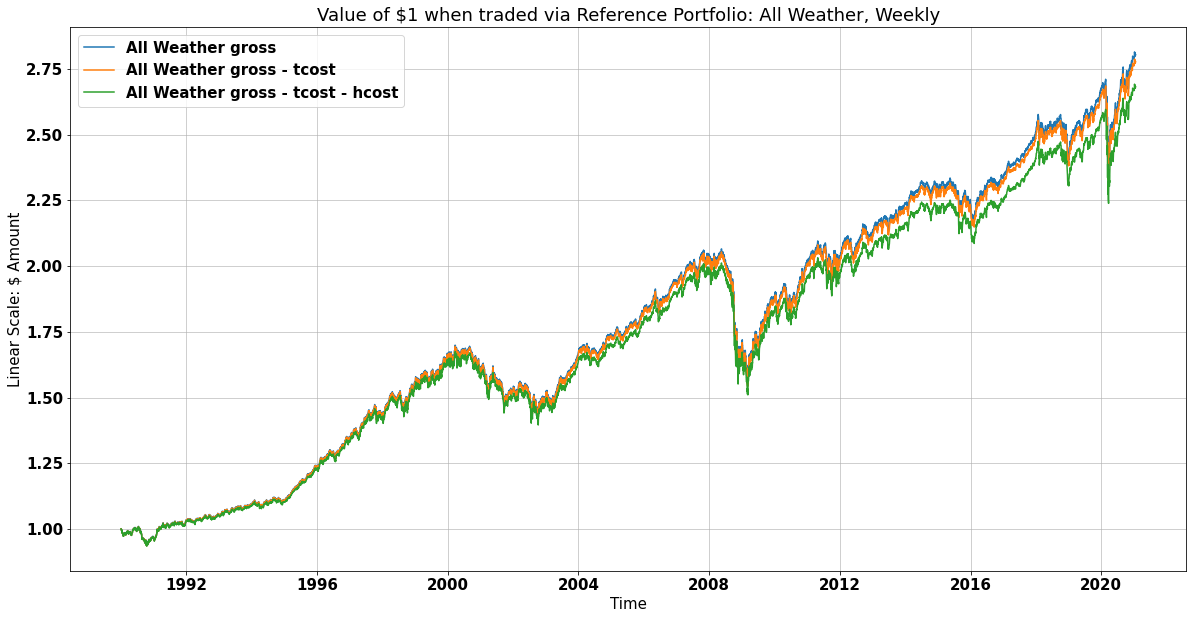

In [9]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=aw_V_t, 
                    strategy_name="Reference Portfolio: All Weather, Weekly", 
                    initial_book_size=1, 
                    scale= 'linear')

In [9]:
rtn_mat['rf_ret'] = rtn_mat['LT Bond']

In [11]:
indicator = bt.Indicator()
aw_stats = indicator.agg_stats(aw_log_ret, 
                               rtn_mat, 
                               aw_V_t,
                               aw_turnover_df)
visualizer.show_stats(aw_stats)

                                                            Mean Annualized Performance Statistics
+-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                   |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| All Weather gross                 |           0.37 |          3.39 |             5.95 |          47.47 |      -0.04 |       0.05 |             -24.84 |
| All Weather gross - tcost         |           0.37 |          3.36 |             5.95 |          47.47 |      -0.04 |       0.05 |             -24.88 |
| All Weather gross - tcost - hcost |           0.35 |          3.24 |             5.95 |          47.46 |      -0.04 |       0.05 

# Monthly

In [12]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 21,
                        data_time_step_days = 1)

In [13]:
aw_simulator = bt.Simulator("All Weather", initial_book_size=1)
aw_weights_lag = aw_simulator.add_weights_lag(aw_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
aw_V_t_m, aw_log_ret_m, aw_turnover_df_m = aw_simulator.cal_pnl(aw_weights_lag, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

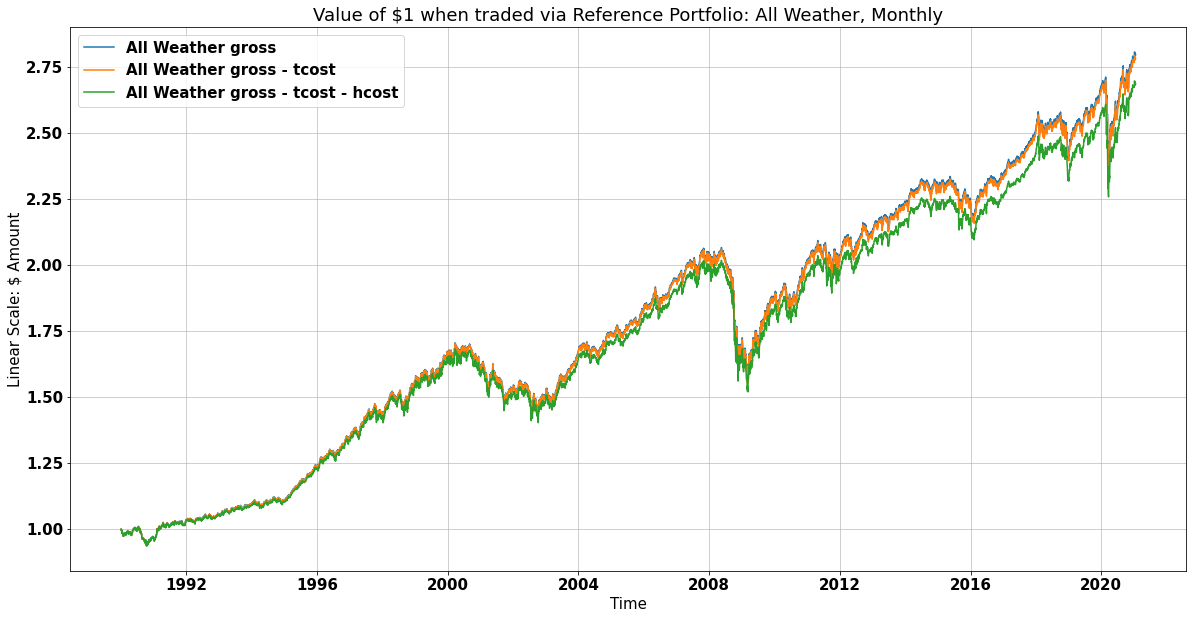

In [14]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=aw_V_t_m, 
                    strategy_name="Reference Portfolio: All Weather, Monthly", 
                    initial_book_size=1, 
                    scale= 'linear')

In [15]:
indicator = bt.Indicator()
aw_stats = indicator.agg_stats(aw_log_ret_m, 
                               rtn_mat, 
                               aw_V_t_m,
                               aw_turnover_df_m)
visualizer.show_stats(aw_stats)

                                                            Mean Annualized Performance Statistics
+-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                   |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| All Weather gross                 |           0.38 |          3.38 |             5.89 |          24.91 |      -0.04 |       0.04 |             -24.59 |
| All Weather gross - tcost         |           0.37 |          3.36 |             5.89 |          24.91 |      -0.04 |       0.04 |             -24.61 |
| All Weather gross - tcost - hcost |           0.35 |          3.25 |             5.89 |          24.9  |      -0.04 |       0.04 

# Quarterly

In [16]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 63,
                        data_time_step_days = 1)

In [17]:
aw_simulator = bt.Simulator("All Weather", initial_book_size=1)
aw_weights_lag = aw_simulator.add_weights_lag(aw_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
aw_V_t_q, aw_log_ret_q, aw_turnover_df_q = aw_simulator.cal_pnl(aw_weights_lag, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

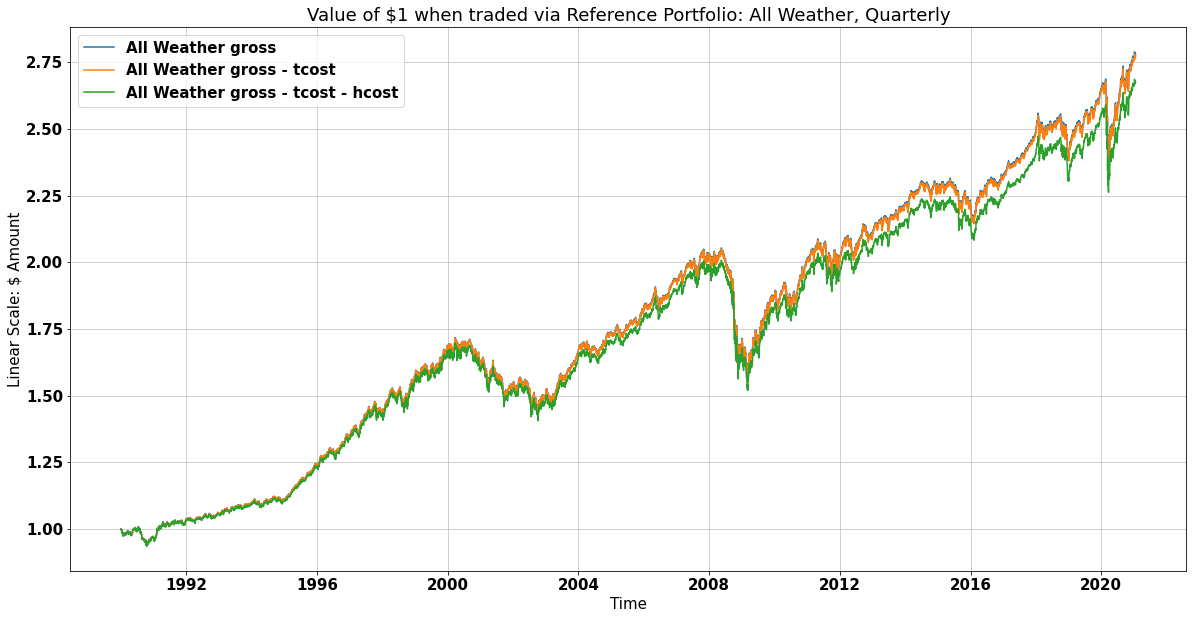

In [18]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=aw_V_t_q, 
                    strategy_name="Reference Portfolio: All Weather, Quarterly", 
                    initial_book_size=1, 
                    scale= 'linear')

In [19]:
indicator = bt.Indicator()
aw_stats = indicator.agg_stats(aw_log_ret_q, 
                               rtn_mat, 
                               aw_V_t_q,
                               aw_turnover_df_q)
visualizer.show_stats(aw_stats)

                                                            Mean Annualized Performance Statistics
+-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                   |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| All Weather gross                 |           0.38 |          3.36 |             5.78 |          15.7  |      -0.04 |       0.04 |             -24.24 |
| All Weather gross - tcost         |           0.38 |          3.35 |             5.78 |          15.7  |      -0.04 |       0.04 |             -24.25 |
| All Weather gross - tcost - hcost |           0.36 |          3.24 |             5.78 |          15.69 |      -0.04 |       0.04 

# Semi-Annually

In [20]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 126,
                        data_time_step_days = 1)

In [21]:
aw_simulator = bt.Simulator("All Weather", initial_book_size=1)
aw_weights_lag = aw_simulator.add_weights_lag(aw_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
aw_V_t_SA, aw_log_ret_SA, aw_turnover_df_SA = aw_simulator.cal_pnl(aw_weights_lag, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

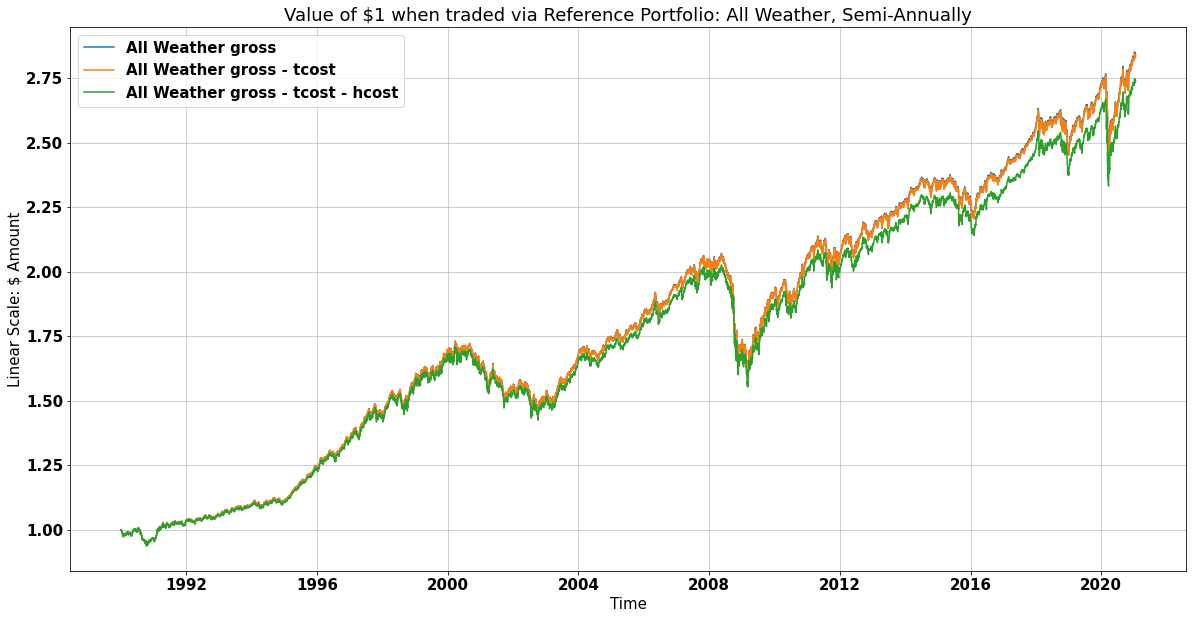

In [22]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=aw_V_t_SA, 
                    strategy_name="Reference Portfolio: All Weather, Semi-Annually", 
                    initial_book_size=1, 
                    scale= 'linear')

In [23]:
indicator = bt.Indicator()
aw_stats = indicator.agg_stats(aw_log_ret_SA, 
                               rtn_mat, 
                               aw_V_t_SA,
                               aw_turnover_df_SA)
visualizer.show_stats(aw_stats)

                                                            Mean Annualized Performance Statistics
+-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                   |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| All Weather gross                 |           0.4  |          3.43 |             5.72 |          12.97 |      -0.04 |       0.03 |             -23.24 |
| All Weather gross - tcost         |           0.4  |          3.43 |             5.72 |          12.97 |      -0.04 |       0.03 |             -23.25 |
| All Weather gross - tcost - hcost |           0.38 |          3.31 |             5.72 |          12.96 |      -0.04 |       0.03 

# Annually

In [24]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 252,
                        data_time_step_days = 1)

In [25]:
aw_simulator = bt.Simulator("All Weather", initial_book_size=1)
aw_weights_lag = aw_simulator.add_weights_lag(aw_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
aw_V_t_A, aw_log_ret_A, aw_turnover_df_A = aw_simulator.cal_pnl(aw_weights_lag, 
                                                          rtn_mat.iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

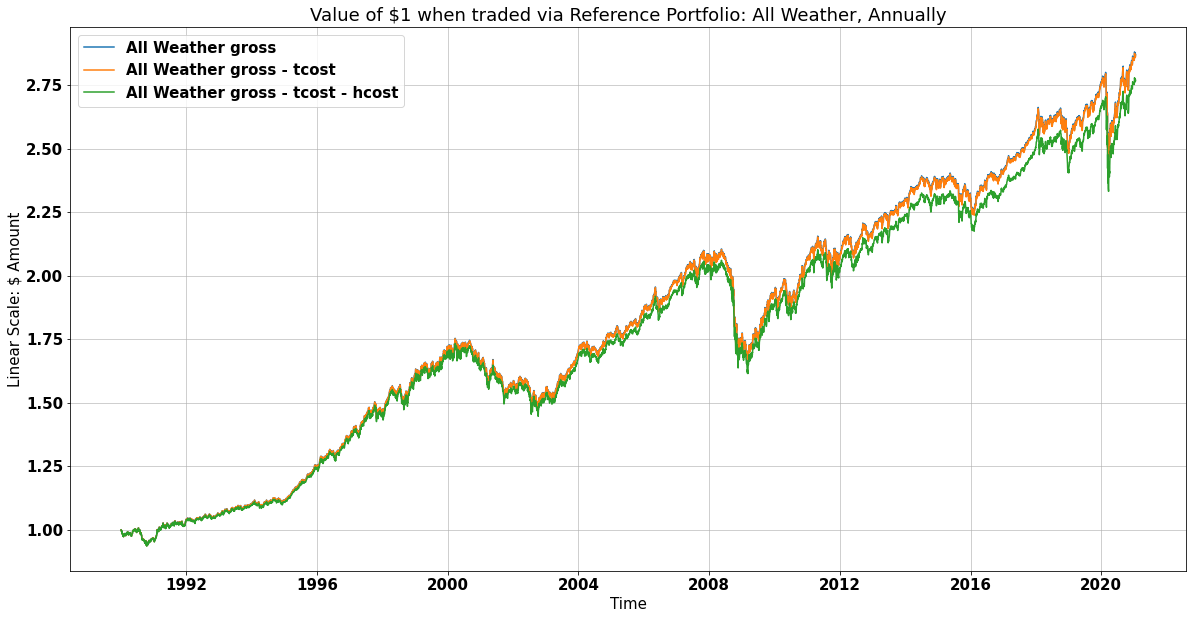

In [26]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=aw_V_t_A, 
                    strategy_name="Reference Portfolio: All Weather, Annually", 
                    initial_book_size=1, 
                    scale= 'linear')

In [27]:
indicator = bt.Indicator()
aw_stats = indicator.agg_stats(aw_log_ret_A, 
                               rtn_mat, 
                               aw_V_t_A,
                               aw_turnover_df_A)
visualizer.show_stats(aw_stats)

                                                            Mean Annualized Performance Statistics
+-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                   |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|-----------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| All Weather gross                 |           0.4  |          3.47 |             5.71 |          10.84 |      -0.05 |       0.04 |             -21.54 |
| All Weather gross - tcost         |           0.4  |          3.46 |             5.71 |          10.84 |      -0.05 |       0.04 |             -21.55 |
| All Weather gross - tcost - hcost |           0.38 |          3.35 |             5.71 |          10.84 |      -0.05 |       0.04 

# Frequency Conclusion

Based on the Sharpe Ratio and consideration of the portfolio components' cyclicality, we conclude that **Annually** and **Semi-Annually** have the overall best performance

# Optional Risk Parity

In [10]:
rp_model = rp.RiskParity(1,list(rtn_mat.iloc[:,:-1].columns),rtn_mat.iloc[:,:-1],252,10,252)
trade, trade_pct, rp_weights, returns = rp_model.get_flow()

cols = [c for c in rp_weights if 'target' in c]
rp_weights = rp_weights[cols]
rp_weights.columns = rtn_mat.columns[:-1]
rp_weights = rp_weights.divide(rp_weights.sum(axis=1),axis=0)

/home/jupyter/factor_timing/risk_parity.py:47: RuntimeWarning: divide by zero encountered in true_divide
  trade_weight = trade[i - 1] / (NAV[i] * target_weights[i])


In [11]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 21,
                        data_time_step_days = 1)

In [13]:
rp_simulator = bt.Simulator("Risk Parity Weighted", initial_book_size=1)
rp_weights_lag = rp_simulator.add_weights_lag(rp_weights, lag=0)
tc_coeff=np.array([0.0005,0.,0.,0.002,0.002])
hc_coeff = np.array([0., 0.,0.,0.0075,0.0075])
rp_V_t_m, rp_log_ret_m, rp_turnover_df_m = rp_simulator.cal_pnl(rp_weights_lag, 
                                                          rtn_mat.loc[rp_weights.index].iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

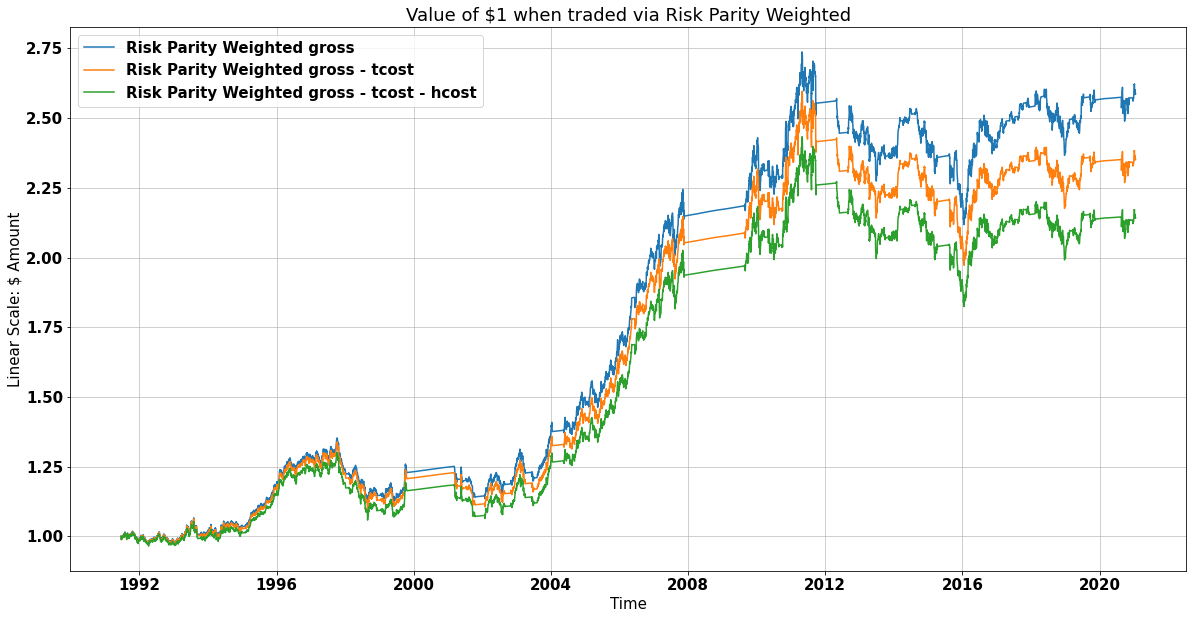

In [16]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=rp_V_t_m, 
                    strategy_name="Risk Parity Weighted", 
                    initial_book_size=1, 
                    scale= 'linear')

In [15]:
indicator = bt.Indicator()
rp_stats = indicator.agg_stats(rp_log_ret_m, 
                               rtn_mat.loc[rp_weights.index], 
                               rp_V_t_m,
                               rp_turnover_df_m)
visualizer.show_stats(rp_stats)

                                                            Mean Annualized Performance Statistics
+--------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                            |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|--------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Risk Parity Weighted gross                 |           0.33 |          3.28 |             6.46 |         436.25 |      -0.02 |       0.02 |             -22.64 |
| Risk Parity Weighted gross - tcost         |           0.28 |          2.95 |             6.46 |         436.25 |      -0.02 |       0.02 |             -24.04 |
| Risk Parity Weighted gross - tcost - hcost |           0.23 |          2.63 |       